## Time series prediction

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from utils import MACD, RSI, Drawdown_current, volatility_rolling, extract, Close_price, log_return, WFCV
import statsmodels.api as sm

In [2]:
returns_all = pd.read_csv('230216_returns.csv')

In [ ]:
co1_comdty = extract(returns_all, 'CO1 Comdty')
co1_comdty["Close"] = Close_price(co1_comdty)
co1_comdty["log_return"] = log_return(co1_comdty)

In [ ]:
co1_comdty["MACD"] = MACD(co1_comdty)
co1_comdty["RSI"] = RSI(co1_comdty)
co1_comdty["Drawdown"] = Drawdown_current(co1_comdty)
co1_comdty["Volatility_20"] = volatility_rolling(co1_comdty, window=20)
co1_comdty["Volatility_60"] = volatility_rolling(co1_comdty, window=60)
lags = list(range(1, 11))
for lag in lags:
    co1_comdty[f'lag_{lag}'] = co1_comdty['log_return'].shift(lag)

In [ ]:
X = co1_comdty.dropna().drop(columns=['log_return', 'Close', 'return'])
y = co1_comdty.dropna()['log_return']

print("Taille de l'échantillon:", X.shape)


Taille de l'échantillon: (5827, 15)


In [ ]:
# Tuning the RF with Grid search CV

def fine_tune_rf_wfcv(X, y, param_grid, fold_size=200, step_size=50):
    # On prend les 1000 premiers points pour tuner
    X_sub = X.iloc[:1000]
    y_sub = y.iloc[:1000]
    best_score = float('inf')
    best_params = None
    grid = ParameterGrid(param_grid)
    
    for params in grid:
        model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
        preds, truths, mses, r2 = WFCV(X_sub, y_sub, model, step_size, fold_size)
        
        current_mse = mses[-1]
        if current_mse < best_score:
            best_score = current_mse
            best_params = params
            
    print(f"Meilleurs paramètres : {best_params}")
    return best_params

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, None],
    'min_samples_leaf': [5, 10]
}

best_params = fine_tune_rf_wfcv(X, y, param_grid)
rf = RandomForestRegressor(**best_params, random_state=42)

Meilleurs paramètres : {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 100}


In [18]:
rf_pred, rf_truth, rf_mse, rf_r2 = WFCV(X, y, rf)

In [19]:
reg = sm.OLS(rf_truth, sm.add_constant(rf_pred)).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     185.0
Date:                Mon, 02 Feb 2026   Prob (F-statistic):           1.86e-41
Time:                        12:24:49   Log-Likelihood:                 12304.
No. Observations:                5400   AIC:                        -2.460e+04
Df Residuals:                    5398   BIC:                        -2.459e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.029      0.3

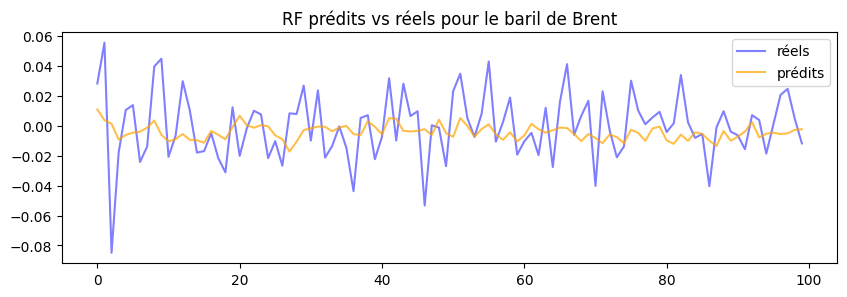

In [20]:
plt.figure(figsize=(10, 3))
plt.plot(rf_truth[:100], label='réels', color='b', alpha=0.5)
plt.plot(rf_pred[:100], label='prédits', color='orange', alpha=0.7)
plt.title('RF prédits vs réels pour le baril de Brent')
plt.legend()
plt.show()

In [21]:
cl1_comdty = extract(returns_all, 'CL1 Comdty')
cl1_comdty["Close"] = Close_price(cl1_comdty)
cl1_comdty["log_return"] = log_return(cl1_comdty)

c:\Users\diane\time-series-pred\tspenv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
cl1_comdty["MACD"] = MACD(cl1_comdty)
cl1_comdty["RSI"] = RSI(cl1_comdty)
cl1_comdty["Drawdown"] = Drawdown_current(cl1_comdty)
cl1_comdty["Volatility_20"] = volatility_rolling(cl1_comdty, window=20)
cl1_comdty["Volatility_60"] = volatility_rolling(cl1_comdty, window=60)
lags = list(range(1, 11))
for lag in lags:
    cl1_comdty[f'lag_{lag}'] = cl1_comdty['log_return'].shift(lag)

In [23]:
X = cl1_comdty.dropna().drop(columns=['log_return', 'Close', 'return'])
y = cl1_comdty.dropna()['log_return']

print("Taille de l'échantillon:", X.shape)

rf_pred, rf_truth, rf_mse, rf_r2 = WFCV(X, y, rf)

Taille de l'échantillon: (5639, 15)


In [24]:
reg = sm.OLS(rf_truth, sm.add_constant(rf_pred)).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     185.0
Date:                Mon, 02 Feb 2026   Prob (F-statistic):           1.86e-41
Time:                        12:25:11   Log-Likelihood:                 12304.
No. Observations:                5400   AIC:                        -2.460e+04
Df Residuals:                    5398   BIC:                        -2.459e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.029      0.3

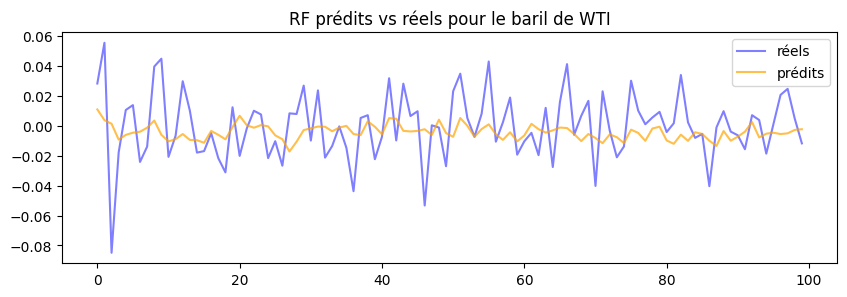

In [25]:
plt.figure(figsize=(10, 3))
plt.plot(rf_truth[:100], label='réels', color='b', alpha=0.5)
plt.plot(rf_pred[:100], label='prédits', color='orange', alpha=0.7)
plt.title('RF prédits vs réels pour le baril de WTI')
plt.legend()
plt.show()

In [26]:
ng1_comdty = extract(returns_all, 'NG1 Comdty')
ng1_comdty["Close"] = Close_price(ng1_comdty)
ng1_comdty["log_return"] = log_return(ng1_comdty)

In [27]:
ng1_comdty["MACD"] = MACD(ng1_comdty)
ng1_comdty["RSI"] = RSI(ng1_comdty)
ng1_comdty["Drawdown"] = Drawdown_current(ng1_comdty)
ng1_comdty["Volatility_20"] = volatility_rolling(ng1_comdty, window=20)
ng1_comdty["Volatility_60"] = volatility_rolling(ng1_comdty, window=60)
lags = list(range(1, 11))
for lag in lags:
    ng1_comdty[f'lag_{lag}'] = ng1_comdty['log_return'].shift(lag)

In [28]:
X = ng1_comdty.dropna().drop(columns=['log_return', 'Close', 'return'])
y = ng1_comdty.dropna()['log_return']

print("Taille de l'échantillon:", X.shape)


Taille de l'échantillon: (5689, 15)


In [29]:
rf_pred, rf_truth, rf_mse, rf_r2 = WFCV(X, y, rf)

In [30]:
reg = sm.OLS(rf_truth, sm.add_constant(rf_pred)).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     190.2
Date:                Mon, 02 Feb 2026   Prob (F-statistic):           1.49e-42
Time:                        13:24:14   Log-Likelihood:                 10545.
No. Observations:                5450   AIC:                        -2.109e+04
Df Residuals:                    5448   BIC:                        -2.107e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.89e-05      0.000      0.167      0.8

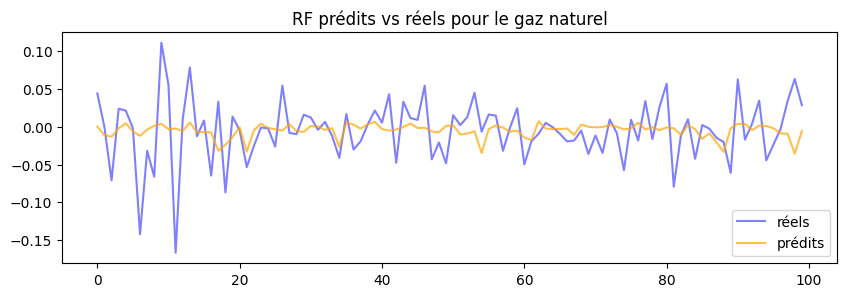

In [31]:
plt.figure(figsize=(10, 3))
plt.plot(rf_truth[:100], label='réels', color='b', alpha=0.5)
plt.plot(rf_pred[:100], label='prédits', color='orange', alpha=0.7)
plt.title('RF prédits vs réels pour le gaz naturel')
plt.legend()
plt.show()